# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
import tensorflow as tf

# Check version of tensorflow
print(tf.__version__)

# Check if we have a GPU available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

2.17.0
Default GPU Device: /device:GPU:0


In [2]:
# Check and download the needed packages
import importlib

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        !pip install {package}

# Download the needed packages
for package in ['PyGithub']:
    install_if_missing(package)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 44.1 MB/s eta 0:00:00


In [3]:
from github import Github

# Authentication is defined via github.Auth
from github import Auth

# Read only access to deep_learning repo
auth = Auth.Token()

# Public web Github
with Github(auth=auth) as gh:
    # Get deep_learning repo
    repo = gh.get_repo('jsoych/deep_learning')

    # Get metadata.csv from downloaded_books directory
    contents = repo.get_contents(path='02_activities/assignments/downloaded_books/metadata.csv')
    rawdata = contents.decoded_content

    # Write content to working directory
    with open(contents.name, 'wb') as f:
        f.write(rawdata)

In [4]:
import os
import pandas as pd
import requests

# Load metadata
metadata = pd.read_csv('metadata.csv')

# Make shakespeare directory
if not(os.path.isdir('shakespeare')):
    os.mkdir('shakespeare')

# Download files and save files to shakespeare dictory
for url in metadata['URL']:
    # Get filename
    head, filename = os.path.split(url)

    # Create filepath
    filepath = os.path.join('shakespeare', filename)

    # Write the request body to filepath as text
    if not(os.path.exists(filepath)):
        r = requests.get(f'{url}')
        if (r.status_code == 200):
            with open(filepath, 'w', encoding='utf-8') as f:
                f.write(r.text)
        else:
            print(f'{url} status code {r.status_code}')

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [5]:
# Get data from files in shakespeare directory
texts = []
with os.scandir('shakespeare') as dir_entries:
    for e in dir_entries:
        # Check if e is a file
        if not(e.is_file()):
            continue

        # Read file and store text in data dictionary
        with open(e.path, 'r', encoding='utf-8') as f:
            text = f.read()
            if text: # Check if text is empty
                texts.append(text)
            else:
                print(f'{e.name} is empty')

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [6]:
# Define OOV_TOKEN
OOV_TOKEN = 'unknown'

# Create tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=OOV_TOKEN,
    analyzer=None
)

# Split texts into train, validation, and test texts
train_texts = texts[0:4]
val_texts = texts[4:5]
test_texts = texts[5:6]

# Fit tokenizer on train texts
tokenizer.fit_on_texts(train_texts)

# Get vocab size from fitted tokenizer
VOCAB_SIZE = 0
for seq in tokenizer.texts_to_sequences(train_texts):
    curr_max = max(seq)
    if (VOCAB_SIZE < curr_max):
        VOCAB_SIZE = curr_max

# Add OOV_TOKEN to VOCAB_SIZE
VOCAB_SIZE += 1

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [7]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it.")

[('unknown', 2492), ('the', 2), ('and', 3), ('to', 4), ('of', 5), ('in', 6), ('a', 7), ('i', 8), ('ff', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [8]:
import math
import numpy as np

class DataGenerator(tf.keras.utils.PyDataset):

    """ DataGenerator prepares and batches data from a corpus. """

    def __init__(
            self,
            corpus,
            vocab_size,
            tokenizer,
            batch_size=32,
            seq_len=1024,
            **kwargs
        ):
        """
        Args:
            corpus: The corpus of text needed to generate batches.
            vocab_size: The size of the fitted tokenizer vocabulary.
            tokenizer: The fitted tokenizer used to tokenize the text.
            batch_size: The size of each batch.
            seq_len: The length of each sequence in each batch.
        """
        super().__init__(**kwargs)
        self.corpus = corpus
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.sequences = tokenizer.texts_to_sequences(corpus)

    def __len__(self):
        """ Returns the total number of batches. """
        tot_len = 0
        for seq in self.sequences:
            tot_len += max(len(seq) - self.seq_len - 1, 0)
        return math.ceil(tot_len / self.batch_size)

    def __getitem__(self, idx):
        """ Gets the idx'th batch of data. """
        X_batch = []
        y_batch = []
        batch_size = self.batch_size
        low = idx * self.batch_size
        for seq in self.sequences:
            # Check low against the number of tokens in the current text
            if (low > (max(len(seq) - self.seq_len - 1, 0))):
                low -= (max(len(seq) - self.seq_len - 1, 0))
                continue

            # Compute the upper index bound
            high = min(low + batch_size, len(seq) - self.seq_len - 1)

            for i in range(low, high):
                # Check if y is oov_token
                y = seq[i + self.seq_len]
                if (y == self.tokenizer.oov_token):
                    continue

                # Add X to X_batch
                X_batch.append(seq[i : i + self.seq_len])

                # Add y to y_batch
                y_batch.append(y)

                # Deincrement batch_size
                batch_size -= 1

            # Check if batch_size is zero
            if not(batch_size):
                break

            # Set low to zero
            low = 0

        return np.array(X_batch), np.array(y_batch)

    def summary(self):
        """ Prints a summary of the data generator. """
        s = f'number of texts in corpus is {len(self.corpus)}\n'
        print(s)

In [9]:
# Define global variables
SEQ_LENGTH = 1024
BATCH_SIZE = 128

train_data_gen = DataGenerator(
    corpus=train_texts,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    seq_length=SEQ_LENGTH
)
train_data_gen.summary()

val_data_gen = DataGenerator(
    corpus=val_texts,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    seq_length=SEQ_LENGTH
)
val_data_gen.summary()

number of texts in corpus is 4

number of texts in corpus is 1



In [11]:
# Get example X_batch and y_batch
X_batch, y_batch = train_data_gen.__getitem__(0)

In [12]:
# Print example X_batch and y_batch
for words, target in zip(tokenizer.sequences_to_texts([seq[-5:] for seq in X_batch]), y_batch):
    print(f'{words} {target}')

his deed or he his 2815
deed or he his manage 32
or he his manage by 9038
he his manage by thâ 89
his manage by thâ well 1420
manage by thâ well doing 4593
by thâ well doing steed 14396
thâ well doing steed âbut 988
well doing steed âbut quickly 39
doing steed âbut quickly on 22
steed âbut quickly on this 677
âbut quickly on this side 2
quickly on this side the 6263
on this side the verdict 473
this side the verdict went 14
side the verdict went his 2951
the verdict went his real 21862
verdict went his real habitude 375
went his real habitude gave 179
his real habitude gave life 3
real habitude gave life and 277
habitude gave life and grace 4
gave life and grace to 21863
life and grace to appertainings 3
and grace to appertainings and 4
grace to appertainings and to 14402
to appertainings and to ornament 21864
appertainings and to ornament accomplishâd 6
and to ornament accomplishâd in 201
to ornament accomplishâd in himself 20
ornament accomplishâd in himse

# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [16]:
from keras import Sequential, Input
from keras.layers import Embedding, LSTM, Dense

model = Sequential(name='rnn')
model.add(Embedding(VOCAB_SIZE, 256, name='embedding_layer'))
model.add(LSTM(256, name='lstm_layer'))
model.add(Dense(VOCAB_SIZE, activation='softmax', name='output_layer'))
model.summary()

Model: "rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

Generating the next word is similar to sentiment analysis or image classification. If we consider the next word as a class, then a natural choice for our loss function is categorical cross entropy. A good start for optimizer is Adam, since it includes an adaptive learning rate.

In [17]:
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam())

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [20]:
history = model.fit(
    x=train_data_gen,
    epochs=5,
    batch_size=train_data_gen.batch_size,
    validation_data=val_data_gen,
    validation_batch_size=val_data_gen.batch_size
)

Epoch 1/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 334s 76ms/step - loss: 6.1736 - val_loss: 6.7633
Epoch 2/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 335s 76ms/step - loss: 5.5436 - val_loss: 6.8382
Epoch 3/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 334s 76ms/step - loss: 5.0101 - val_loss: 7.0380
Epoch 4/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 335s 76ms/step - loss: 4.4800 - val_loss: 7.2480
Epoch 5/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 335s 76ms/step - loss: 4.0092 - val_loss: 7.4537


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

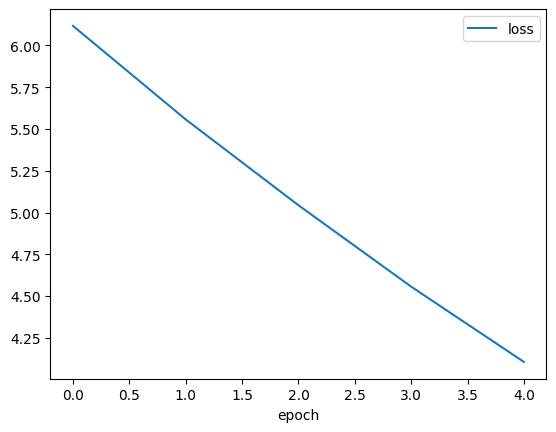

In [21]:
import matplotlib.pyplot as plt

def plot_history(history, *args):
    for arg in args:
        plt.plot(history.history[arg], label=f"{arg}")
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

plot_history(history, 'loss')

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [54]:
from keras.utils import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE+1), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    # Tokenize seed text
    seq = tokenizer.texts_to_sequences([seed_text])

    for i in range(max_sequence_len-1):
        # Pad sequence with zeros
        padded_seq = pad_sequences(seq, maxlen=max_sequence_len)

        # Get model prediction
        seq[0].append(get_predicted_word(model, padded_seq))

    return tokenizer.sequences_to_texts(seq)


In [55]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', train_data_gen.seq_len)

["hamlet 4950 80 et un amoy de de nails de arma de coun de coun alice de parte alice de elbow la de nails allice de de foot alice m'en kath de elbow de nick de de de de nails de nick de de de an menton an nails alice sauf votre honneur de elbow kath m'en remercã®mens de mails alice de nails de despised de nails madame de coun de coun alice oui kath de coun 5396 kath je reciterai je reciterai sly de weeds maison madame fetch my fortunes for a hundred title to smooth land egregious slow that must yet god 5230 or let me feel your highness 6815 50 all my father o my lords be spoken with you 4433 3860 mowb i comes qâ\x82\x86 1642 well cap paid 98 k hen if we were good convey a number de cudie and yet kate is 3764 gow if name your lordship is sounded fran my lord the earl of westmoreland pist singing of two soldiers 31 120 some man of the parents being carried it hither lord philip scroop spur fair love that was this business broke with my heart that with the land 1886 35 ff a true to the ki

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [56]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-14 16:00:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.14MB/s    in 13m 59s 

2024-08-14 16:14:34 (1003 KB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [57]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [58]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < (VOCAB_SIZE+1):
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [64]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE,
        100,
        weights=[embedding_matrix],
        input_length=1024,
        trainable=False,
        name='glove_embedding_layer'
    )

In [65]:
# Create new model
new_model = Sequential(name='new_hamlet_model')
new_model.add(embedding_layer)
new_model.add(LSTM(256, name='lstm_layer'))
new_model.add(Dense(VOCAB_SIZE, activation='softmax', name='output_layer'))
new_model.summary()

Model: "new_hamlet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ glove_embedding_layer (Embedding)    │ ?                           │       3,283,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,283,000 (12.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,283,000 (12.52 MB)

In [67]:
new_model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam())

In [68]:
history = new_model.fit(
    x=train_data_gen,
    epochs=5,
    batch_size=train_data_gen.batch_size,
    validation_data=val_data_gen,
    validation_batch_size=val_data_gen.batch_size
)

Epoch 1/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 281s 63ms/step - loss: 7.4207 - val_loss: 6.9281
Epoch 2/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 279s 63ms/step - loss: 6.2583 - val_loss: 6.8037
Epoch 3/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 279s 63ms/step - loss: 5.7481 - val_loss: 6.8184
Epoch 4/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 279s 63ms/step - loss: 5.3203 - val_loss: 6.8805
Epoch 5/5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 279s 63ms/step - loss: 4.9384 - val_loss: 6.9562


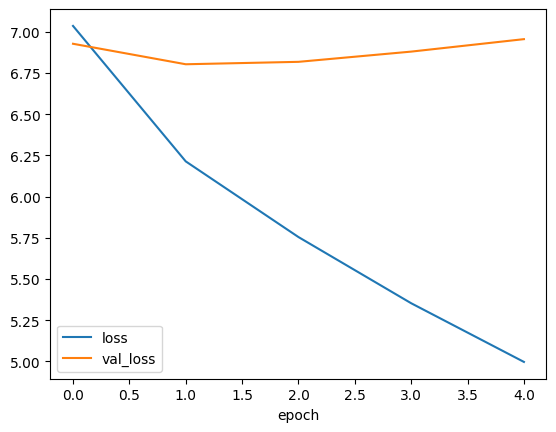

In [71]:
plot_history(history, 'loss', 'val_loss')

In [70]:
# Generate text with new model
generate_text(new_model, tokenizer, 'hamlet', train_data_gen.seq_len)

["hamlet expectation qâ\x82\x85 fâ\x82\x84 fâ\x82\x84 1900 assume where's qâ\x82\x85 drums qâ\x82\x83 she fâ\x82\x83 self ff combine their poisonous smyth come fast and kettle siege set forward and dews fire to griefe ff 3845 rann tapsters 1670 25 ff who she set qâ\x82\x81 the heath conj cap dev mus imp and bodl 1 2 qâ\x82\x83 for with a siege or a king a room qâ\x82\x81 if pope a head qâ\x82\x81 qâ\x82\x82 and prisons had through the most number of the first of the scene at the quartos in s s g 3626 donne pastoral rambures ed harness harness thrust rowe ed 2 3756 fâ\x82\x83 5278 qâ\x82\x83 old way heare glad my thrifts he told 670 how that ff these capell all in rowe ff and here is johnson erased as flown 3293 ff qâ\x82\x85 om steevens conj 6345 but yet fâ\x82\x84 fâ\x82\x84 there note qâ\x82\x81 q fâ\x82\x83 this hour tis ff and you not pope 3962 god heaven theobald heaven ff hark ff 3935 smot the duke om q a q fâ\x82\x81 a ff in a council to harrie 575 favourite god q heaven pope 43

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.